In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from astropy.time import Time

from pysr import PySRRegressor

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [ ]:
dat_file = "E:\Research\SR\input\mag_Indices" + "\R5_0\PREDSOLARWIND\GONGZfield_line1R000_R5.0.dat"

def jd2dt(jd_series, bias=2440000.00):
    """
    Convert Julian date to datetime.
    """
    return Time(jd_series + bias, format="jd").to_datetime()

def get_mag_indices(dat_file, tol="1h") -> pd.DataFrame:
    """
    Get a WSA table from a file.
    """
    jul_bias = 2440000.00
    tol = pd.to_timedelta(tol)

    # Read the WSA data
    wsa_df = pd.read_csv(dat_file, comment='#', sep=r'\s+', engine='python')

    wsa_df["departure_time"] = jd2dt(wsa_df["parcel_depart_time"], jul_bias)
    wsa_df["arrival_time"]   = jd2dt(wsa_df["juldate"], jul_bias)

    # set the time range to 12 hours 
    hr        = wsa_df["arrival_time"].dt.hour
    midnight  = wsa_df["arrival_time"].dt.normalize()
    noon_snap = midnight + pd.Timedelta(hours=12)

    near_midnight = (wsa_df["arrival_time"] - midnight).abs() <= tol
    near_noon     = (wsa_df["arrival_time"] - noon_snap).abs() <= tol

    wsa_df["masked_arrival_time"] = np.select(
        [near_noon, near_midnight],
        [noon_snap, midnight],
        default=pd.NaT
    )

    # Create a timeline DataFrame with 12-hour intervals
    # 2012-01-01 00:00:00 to 2024-12-31 12:00:00
    timeline = pd.DataFrame(
        {"datetime": pd.date_range("2012-01-01", "2024-12-31 12:00", freq="12h")}
    )
    # Merge the WSA data with the timeline
    merged = timeline.merge(wsa_df, left_on="datetime", right_on="masked_arrival_time", how="left")

    avg_cols   = ["expansion_factor", "coronal_hole_dist", "squashing_factor"]
    agg = {**{c: "mean" for c in avg_cols},
           **{c: "first" for c in merged.columns.difference(avg_cols + ["datetime"])}}

    mag_df = (
        merged.groupby("datetime", as_index=False).agg(agg)
              [["datetime", "departure_time", "arrival_time", *avg_cols]]
    )

    mag_df[["departure_time", "arrival_time"]] = mag_df[
        ["departure_time", "arrival_time"]
    ].apply(pd.to_datetime, errors="coerce")

    for col in ["departure_time", "arrival_time"]:
        mag_df[col] = (
            mag_df[col]
            .dt.strftime("%Y-%m-%dT%H:%M:%S")   # ISO-8601 형식
            .fillna(pd.NaT)                      # NaT → <NA>
        )

    return mag_df

In [125]:
df = get_mag_indices(dat_file)
df

ValueError: You are trying to merge on datetime64[ns] and object columns for key 'datetime'. If you wish to proceed you should use pd.concat

In [2]:
input_ch_path = "E:\Research\SR\input\CH_Indices"
input_mag_path = "E:\Research\SR\input\mag_Indices"
output_path = "E:\Research\SR\output"

# input
def load_wsa_table(path: str) -> pd.DataFrame:
    """
    Load WSA table from a file.
    """
    juldate_bias = 2440000.00

    df = pd.read_csv(
        input_mag_path + path,
        comment='#',
        delim_whitespace=True
    )
    dep_iso = Time(df['parcel_depart_time'] + juldate_bias, format='jd').isot
    df.insert(0, 'departure_time', [s.split('.')[0] for s in dep_iso])

    arr_iso = Time(df['juldate'] + juldate_bias, format='jd').isot
    df.insert(1, 'arrival_time',   [s.split('.')[0] for s in arr_iso])

    return df

mag_indics_r5_0  = load_wsa_table("\R5_0\PREDSOLARWIND\GONGZfield_line1R000_R5.0.dat")  # dataframe
mag_indics_r21_5 = load_wsa_table("\R21_5\PREDSOLARWIND\GONGZfield_line1R000.dat")      # dataframe

CH_indics_193 = pd.read_csv(input_ch_path+"\CH_Indics_193.csv")    # dataframe
CH_indics_211 = pd.read_csv(input_ch_path+"\CH_Indics_211.csv")    # dataframe

# output
omni_speed = pd.DataFrame(columns=['datetime', 'speed'])        # dataframe
rows = []

with open(output_path + "\omni2_2000-2024.lst") as f:
    for line in f:
        year, doy, hour, speed = line.strip().split()
        year, doy, hour, speed = int(year), int(doy), int(hour), float(speed)
        
        if (year >= 2012) and (hour in (0, 12)):
            dt = datetime(year, 1, 1) + timedelta(days=doy-1, hours=hour)
            dt = dt.strftime("%Y-%m-%dT%H:%M:%S")
            rows.append({"datetime": dt, "speed": speed})

omni_speed = pd.DataFrame(rows, columns=["datetime", "speed"])

C:\Users\AHN\AppData\Local\Temp\ipykernel_15440\2343122587.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
C:\Users\AHN\AppData\Local\Temp\ipykernel_15440\2343122587.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [3]:
mag_indics_r21_5

,departure_time,arrival_time,juldate,month,day,year,doy,Vp,imf,curr_sheet_dist,...,lon_footpoint,lat_footpoint,lon_subsat,lat_subsat,coronal_hole_dist,B_subsat,expansion_factor,squashing_factor,parcel_depart_time,output_file
0,2011-12-29T22:09:59,2012-01-01T20:47:45,15928.3665,1,1,2012,1,519.8,1.0,5.5,...,154.2686,-21.4683,145.0595,-2.7015,3.0824,5.4856,27.8212,0.4336,15925.4236,wsa_201201010554R000_gongz.fits
1,2011-12-30T01:48:17,2012-01-02T02:21:15,15928.5981,1,2,2012,2,506.1,1.0,4.1,...,154.0786,-21.7099,143.0615,-2.7196,2.9537,5.4857,28.9155,1.8045,15925.5752,wsa_201201010554R000_gongz.fits
2,2011-12-30T05:26:26,2012-01-02T11:39:24,15928.9857,1,2,2012,2,469.4,1.0,2.1,...,153.8750,-22.0032,141.0635,-2.7377,2.8369,5.4859,51.7180,3.5212,15925.7267,wsa_201201010554R000_gongz.fits
3,2011-12-29T16:43:40,2012-01-03T00:44:55,15929.5312,1,3,2012,3,353.0,1.0,8.0,...,155.7722,-24.5644,148.0478,-2.6744,1.6669,5.0877,21.2332,0.9065,15925.1970,wsa_201201020554R000_gongz.fits
4,2011-12-29T20:21:50,2012-01-03T13:01:46,15930.0429,1,3,2012,3,325.9,1.0,6.1,...,155.5597,-24.8763,146.0498,-2.6925,1.4197,5.0878,27.6879,0.9323,15925.3485,wsa_201201020554R000_gongz.fits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31307,2025-03-29T02:18:05,2025-04-01T01:28:33,20766.5615,4,1,2025,91,325.6,1.0,22.3,...,12.8064,5.9554,9.4578,-6.6947,3.6764,17.0986,6.4505,0.6189,20763.5959,wsa_202503310014R000_gongz.fits
31308,2025-03-29T05:56:15,2025-04-01T01:28:42,20766.5616,4,1,2025,91,325.6,1.0,20.3,...,12.1552,5.6526,7.4593,-6.6874,3.8835,17.0987,6.7793,0.6373,20763.7474,wsa_202503310014R000_gongz.fits
31309,2025-03-29T09:34:33,2025-04-01T01:28:50,20766.5617,4,1,2025,91,325.6,1.0,18.3,...,11.5470,5.3226,5.4609,-6.6801,4.1537,17.0988,7.2498,0.6061,20763.8990,wsa_202503310014R000_gongz.fits
31310,2025-03-29T13:12:43,2025-04-01T01:28:59,20766.5618,4,1,2025,91,325.6,1.0,16.3,...,11.0154,4.9434,3.4627,-6.6726,4.0007,17.0990,7.8384,0.5768,20764.0505,wsa_202503310014R000_gongz.fits


In [ ]:
mag_indics_r21_5['arrival_time'] = pd.to_datetime(
    mag_indics_r21_5['arrival_time'],
    format='%Y-%m-%dT%H:%M:%S'
)

hr          = mag_indics_r21_5['arrival_time'].dt.hour
mask_noon    = hr.between(11, 12, inclusive='both')    # 11‒13 h
mask_midnight  = (hr >= 23) | (hr < 1)                  # 23‒01 h
mask = mask_noon | mask_midnight

midnight          = mag_indics_r21_5['arrival_time'].dt.floor('D')
masked_arrival_dt = np.select(
    condlist=[mask_noon,          mask_midnight],
    choicelist=[midnight + pd.Timedelta(hours=12), midnight],
    default=pd.NaT
)

mag_indics_r21_5['masked_arrival_time'] = pd.to_datetime(masked_arrival_dt)\
                              .strftime('%Y-%m-%dT%H:%M:%S')


ValueError: list of cases must be same length as list of conditions

In [76]:
mag_indics_r21_5

,departure_time,arrival_time,masked_arrival_time,juldate,month,day,year,doy,Vp,imf,...,lon_footpoint,lat_footpoint,lon_subsat,lat_subsat,coronal_hole_dist,B_subsat,expansion_factor,squashing_factor,parcel_depart_time,output_file
0,2011-12-29T22:09:59,2012-01-01 20:47:45,NaT,15928.3665,1,1,2012,1,519.8,1.0,...,154.2686,-21.4683,145.0595,-2.7015,3.0824,5.4856,27.8212,0.4336,15925.4236,wsa_201201010554R000_gongz.fits
1,2011-12-30T01:48:17,2012-01-02 02:21:15,NaT,15928.5981,1,2,2012,2,506.1,1.0,...,154.0786,-21.7099,143.0615,-2.7196,2.9537,5.4857,28.9155,1.8045,15925.5752,wsa_201201010554R000_gongz.fits
2,2011-12-30T05:26:26,2012-01-02 11:39:24,2012-01-02 12:00:00,15928.9857,1,2,2012,2,469.4,1.0,...,153.8750,-22.0032,141.0635,-2.7377,2.8369,5.4859,51.7180,3.5212,15925.7267,wsa_201201010554R000_gongz.fits
3,2011-12-29T16:43:40,2012-01-03 00:44:55,2012-01-03 00:00:00,15929.5312,1,3,2012,3,353.0,1.0,...,155.7722,-24.5644,148.0478,-2.6744,1.6669,5.0877,21.2332,0.9065,15925.1970,wsa_201201020554R000_gongz.fits
4,2011-12-29T20:21:50,2012-01-03 13:01:46,NaT,15930.0429,1,3,2012,3,325.9,1.0,...,155.5597,-24.8763,146.0498,-2.6925,1.4197,5.0878,27.6879,0.9323,15925.3485,wsa_201201020554R000_gongz.fits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31307,2025-03-29T02:18:05,2025-04-01 01:28:33,NaT,20766.5615,4,1,2025,91,325.6,1.0,...,12.8064,5.9554,9.4578,-6.6947,3.6764,17.0986,6.4505,0.6189,20763.5959,wsa_202503310014R000_gongz.fits
31308,2025-03-29T05:56:15,2025-04-01 01:28:42,NaT,20766.5616,4,1,2025,91,325.6,1.0,...,12.1552,5.6526,7.4593,-6.6874,3.8835,17.0987,6.7793,0.6373,20763.7474,wsa_202503310014R000_gongz.fits
31309,2025-03-29T09:34:33,2025-04-01 01:28:50,NaT,20766.5617,4,1,2025,91,325.6,1.0,...,11.5470,5.3226,5.4609,-6.6801,4.1537,17.0988,7.2498,0.6061,20763.8990,wsa_202503310014R000_gongz.fits
31310,2025-03-29T13:12:43,2025-04-01 01:28:59,NaT,20766.5618,4,1,2025,91,325.6,1.0,...,11.0154,4.9434,3.4627,-6.6726,4.0007,17.0990,7.8384,0.5768,20764.0505,wsa_202503310014R000_gongz.fits


In [ ]:
idx = pd.date_range("2012-01-01 00:00:00",
                    "2024-12-31 12:00:00",
                    freq="12H")          # 시작·끝 모두 포함

df = pd.DataFrame({
    "datetime": idx.strftime("%Y-%m-%dT%H:%M:%S")   # 'T' 들어간 ISO 8601 문자열
})

print(df.head())
print(df.tail())

C:\Users\AHN\AppData\Local\Temp\ipykernel_15440\862913841.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range("2012-01-01 00:00:00",


In [60]:
df['datetime'] = pd.to_datetime(df['datetime'])

mag_indics_r21_5['masked_arrival_time'] = pd.to_datetime(
    mag_indics_r21_5['masked_arrival_time']
)

matched_rows = mag_indics_r21_5.loc[
    mag_indics_r21_5['masked_arrival_time'].isin(df['datetime'])
]

df_merged = df.merge(
    mag_indics_r21_5,               # 오른쪽 DF
    how='left',                     # df 기준으로 유지
    left_on='datetime',             # df의 키
    right_on='masked_arrival_time'  # mag_indics_r21_5의 키
)

In [79]:
df_merged

,datetime,departure_time,arrival_time,masked_arrival_time,juldate,month,day,year,doy,Vp,...,lon_footpoint,lat_footpoint,lon_subsat,lat_subsat,coronal_hole_dist,B_subsat,expansion_factor,squashing_factor,parcel_depart_time,output_file
0,2012-01-01 00:00:00,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-01 12:00:00,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-02 00:00:00,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-01-02 12:00:00,2011-12-30T05:26:26,2012-01-02 11:39:24,2012-01-02 12:00:00,15928.9857,1.0,2.0,2012.0,2.0,469.4,...,153.8750,-22.0032,141.0635,-2.7377,2.8369,5.4859,51.7180,3.5212,15925.7267,wsa_201201010554R000_gongz.fits
4,2012-01-03 00:00:00,2011-12-29T16:43:40,2012-01-03 00:44:55,2012-01-03 00:00:00,15929.5312,1.0,3.0,2012.0,3.0,353.0,...,155.7722,-24.5644,148.0478,-2.6744,1.6669,5.0877,21.2332,0.9065,15925.1970,wsa_201201020554R000_gongz.fits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11909,2024-12-29 12:00:00,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11910,2024-12-30 00:00:00,2024-12-26T05:17:48,2024-12-30 00:15:59,2024-12-30 00:00:00,20674.5111,12.0,30.0,2024.0,365.0,403.6,...,150.2832,-16.0179,152.7610,-2.3360,2.7838,11.1744,337.3415,0.8886,20670.7207,wsa_202412290004R000_gongz.fits
11911,2024-12-30 12:00:00,2024-12-26T16:12:25,2024-12-30 11:57:33,2024-12-30 12:00:00,20674.9983,12.0,30.0,2024.0,365.0,400.2,...,149.8376,-16.3932,146.8134,-2.3913,2.7848,11.1744,386.1967,0.8521,20671.1753,wsa_202412290004R000_gongz.fits
11912,2024-12-31 00:00:00,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
avg_cols = ['expansion_factor', 'coronal_hole_dist', 'squashing_factor']

first_cols = [c for c in df_merged.columns if c not in avg_cols + ['datetime']]

# ⓒ 집계 규칙 딕셔너리 구성
agg_rules = {**{c: 'mean'  for c in avg_cols},
             **{c: 'first' for c in first_cols}}

# ⓓ 'datetime' 이 중복이면 그룹화 → 하나의 행으로
df_final = (
    df_merged
    .groupby('datetime', sort=False, as_index=False)  # 원래 순서 유지
    .agg(agg_rules)
)

In [78]:
df_final

,datetime,expansion_factor,coronal_hole_dist,squashing_factor,departure_time,arrival_time,masked_arrival_time,juldate,month,day,...,curr_sheet_dist,map_age,B_footpoint,lon_footpoint,lat_footpoint,lon_subsat,lat_subsat,B_subsat,parcel_depart_time,output_file
0,2012-01-01 00:00:00,NaN,NaN,NaN,None,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,2012-01-01 12:00:00,NaN,NaN,NaN,None,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,2012-01-02 00:00:00,NaN,NaN,NaN,None,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3,2012-01-02 12:00:00,51.7180,2.8369,3.5212,2011-12-30T05:26:26,2012-01-02 11:39:24,2012-01-02 12:00:00,15928.9857,1.0,2.0,...,2.1,0.0,5.8793,153.8750,-22.0032,141.0635,-2.7377,5.4859,15925.7267,wsa_201201010554R000_gongz.fits
4,2012-01-03 00:00:00,21.2332,1.6669,0.9065,2011-12-29T16:43:40,2012-01-03 00:44:55,2012-01-03 00:00:00,15929.5312,1.0,3.0,...,8.0,0.0,5.7331,155.7722,-24.5644,148.0478,-2.6744,5.0877,15925.1970,wsa_201201020554R000_gongz.fits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9493,2024-12-29 12:00:00,NaN,NaN,NaN,None,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
9494,2024-12-30 00:00:00,337.3415,2.7838,0.8886,2024-12-26T05:17:48,2024-12-30 00:15:59,2024-12-30 00:00:00,20674.5111,12.0,30.0,...,20.2,0.0,229.6494,150.2832,-16.0179,152.7610,-2.3360,11.1744,20670.7207,wsa_202412290004R000_gongz.fits
9495,2024-12-30 12:00:00,386.1967,2.7848,0.8521,2024-12-26T16:12:25,2024-12-30 11:57:33,2024-12-30 12:00:00,20674.9983,12.0,30.0,...,25.3,0.0,257.8881,149.8376,-16.3932,146.8134,-2.3913,11.1744,20671.1753,wsa_202412290004R000_gongz.fits
9496,2024-12-31 00:00:00,NaN,NaN,NaN,None,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [71]:
for i in range(len(df_merged)):
    if df_merged['datetime'][i] == df_merged['datetime'][i+1]:
        print(df_merged['datetime'][i], df_merged['datetime'][i+1])
    

2012-01-22 00:00:00 2012-01-22 00:00:00
2012-02-16 00:00:00 2012-02-16 00:00:00
2012-02-16 00:00:00 2012-02-16 00:00:00
2012-02-16 00:00:00 2012-02-16 00:00:00
2012-02-16 00:00:00 2012-02-16 00:00:00
2012-02-16 00:00:00 2012-02-16 00:00:00
2012-02-16 00:00:00 2012-02-16 00:00:00
2012-02-16 00:00:00 2012-02-16 00:00:00
2012-02-27 00:00:00 2012-02-27 00:00:00
2012-02-27 00:00:00 2012-02-27 00:00:00
2012-03-04 00:00:00 2012-03-04 00:00:00
2012-03-06 12:00:00 2012-03-06 12:00:00
2012-03-06 12:00:00 2012-03-06 12:00:00
2012-03-06 12:00:00 2012-03-06 12:00:00
2012-03-06 12:00:00 2012-03-06 12:00:00
2012-03-13 00:00:00 2012-03-13 00:00:00
2012-03-17 00:00:00 2012-03-17 00:00:00
2012-03-17 00:00:00 2012-03-17 00:00:00
2012-03-17 00:00:00 2012-03-17 00:00:00
2012-03-24 00:00:00 2012-03-24 00:00:00
2012-03-27 00:00:00 2012-03-27 00:00:00
2012-04-15 00:00:00 2012-04-15 00:00:00
2012-04-18 00:00:00 2012-04-18 00:00:00
2012-04-18 00:00:00 2012-04-18 00:00:00
2012-04-18 00:00:00 2012-04-18 00:00:00


KeyError: 11914

In [75]:
df_merged.loc[42:44]

,datetime,departure_time,arrival_time,masked_arrival_time,juldate,month,day,year,doy,Vp,...,lon_footpoint,lat_footpoint,lon_subsat,lat_subsat,coronal_hole_dist,B_subsat,expansion_factor,squashing_factor,parcel_depart_time,output_file
42,2012-01-22 00:00:00,2012-01-18T15:40:27,2012-01-22 23:13:03,2012-01-22,15949.4674,1.0,22.0,2012.0,22.0,355.0,...,221.2597,12.9046,245.2207,-4.8474,2.2042,-5.9347,488.5480,-0.8663,15945.1531,wsa_201201220554R000_gongz.fits
43,2012-01-22 00:00:00,2012-01-18T19:18:37,2012-01-22 23:13:12,2012-01-22,15949.4675,1.0,22.0,2012.0,22.0,355.0,...,221.4352,12.5443,243.2226,-4.8620,2.4182,-5.9348,386.7454,-0.9325,15945.3046,wsa_201201220554R000_gongz.fits
44,2012-01-22 12:00:00,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
df_merged['datetime'][40:50]

40   2012-01-21 00:00:00
41   2012-01-21 12:00:00
42   2012-01-22 00:00:00
43   2012-01-22 00:00:00
44   2012-01-22 12:00:00
45   2012-01-23 00:00:00
46   2012-01-23 12:00:00
47   2012-01-24 00:00:00
48   2012-01-24 12:00:00
49   2012-01-25 00:00:00
Name: datetime, dtype: datetime64[ns]

In [ ]:
omni_speed # 그러면 2012-01-01T00:00:00 부터 12시간 간격으로 2024-12-31T12:00:00에 대한 

,datetime,speed
0,2012-01-01T00:00:00,379.0
1,2012-01-01T12:00:00,366.0
2,2012-01-02T00:00:00,359.0
3,2012-01-02T12:00:00,347.0
4,2012-01-03T00:00:00,403.0
...,...,...
9493,2024-12-29T12:00:00,335.0
9494,2024-12-30T00:00:00,365.0
9495,2024-12-30T12:00:00,341.0
9496,2024-12-31T00:00:00,313.0


In [3]:
SR_df = pd.DataFrame({
    'datetime':         omni_speed['datetime'],
    'speed':            omni_speed['speed'],

    # EUV 193
    'A_CH_193_lag3':    CH_indics_193['A_CH'].shift(6),
    'A_CH_193_lag3p5':  CH_indics_193['A_CH'].shift(7),
    'A_CH_193_lag4':    CH_indics_193['A_CH'].shift(8),
    'A_CH_193_lag4p5':  CH_indics_193['A_CH'].shift(9),
    'A_CH_193_lag5':    CH_indics_193['A_CH'].shift(10),

    'P_CH30_193_lag3':    CH_indics_193['P_CH30'].shift(6),
    'P_CH30_193_lag3p5':  CH_indics_193['P_CH30'].shift(7),
    'P_CH30_193_lag4':    CH_indics_193['P_CH30'].shift(8),
    'P_CH30_193_lag4p5':  CH_indics_193['P_CH30'].shift(9),
    'P_CH30_193_lag5':    CH_indics_193['P_CH30'].shift(10),

    'P_CH90_193_lag3':    CH_indics_193['P_CH90'].shift(6),
    'P_CH90_193_lag3p5':  CH_indics_193['P_CH90'].shift(7),
    'P_CH90_193_lag4':    CH_indics_193['P_CH90'].shift(8),
    'P_CH90_193_lag4p5':  CH_indics_193['P_CH90'].shift(9),
    'P_CH90_193_lag5':    CH_indics_193['P_CH90'].shift(10),

    # EUV 211 
    'A_CH_211_lag3':    CH_indics_211['A_CH'].shift(6),
    'A_CH_211_lag3p5':  CH_indics_211['A_CH'].shift(7),
    'A_CH_211_lag4':    CH_indics_211['A_CH'].shift(8),
    'A_CH_211_lag4p5':  CH_indics_211['A_CH'].shift(9),
    'A_CH_211_lag5':    CH_indics_211['A_CH'].shift(10),

    'P_CH30_211_lag3':    CH_indics_211['P_CH30'].shift(6),
    'P_CH30_211_lag3p5':  CH_indics_211['P_CH30'].shift(7),
    'P_CH30_211_lag4':    CH_indics_211['P_CH30'].shift(8),
    'P_CH30_211_lag4p5':  CH_indics_211['P_CH30'].shift(9),
    'P_CH30_211_lag5':    CH_indics_211['P_CH30'].shift(10),

    'P_CH90_211_lag3':    CH_indics_211['P_CH90'].shift(6),
    'P_CH90_211_lag3p5':  CH_indics_211['P_CH90'].shift(7),
    'P_CH90_211_lag4':    CH_indics_211['P_CH90'].shift(8),
    'P_CH90_211_lag4p5':  CH_indics_211['P_CH90'].shift(9),
    'P_CH90_211_lag5':    CH_indics_211['P_CH90'].shift(10)
    })

In [4]:
SR_df

,datetime,speed,A_CH_193_lag3,A_CH_193_lag3p5,A_CH_193_lag4,A_CH_193_lag4p5,A_CH_193_lag5,P_CH30_193_lag3,P_CH30_193_lag3p5,P_CH30_193_lag4,...,P_CH30_211_lag3,P_CH30_211_lag3p5,P_CH30_211_lag4,P_CH30_211_lag4p5,P_CH30_211_lag5,P_CH90_211_lag3,P_CH90_211_lag3p5,P_CH90_211_lag4,P_CH90_211_lag4p5,P_CH90_211_lag5
0,2012-01-01T00:00:00,379.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-01T12:00:00,366.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-02T00:00:00,359.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-01-02T12:00:00,347.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-01-03T00:00:00,403.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9493,2024-12-29T12:00:00,335.0,0.00000,0.000397,0.002418,0.001910,0.002744,2876.525860,3101.330431,2556.015682,...,5143.805153,6762.748545,5380.355625,5974.310436,6132.148550,13061.27459,15096.39266,13355.93581,14837.83137,14812.58159
9494,2024-12-30T00:00:00,365.0,0.00000,0.000000,0.000397,0.002418,0.001910,3237.390022,2876.525860,3101.330431,...,5226.832649,5143.805153,6762.748545,5380.355625,5974.310436,12649.52370,13061.27459,15096.39266,13355.93581,14837.83137
9495,2024-12-30T12:00:00,341.0,0.00000,0.000000,0.000000,0.000397,0.002418,2994.357499,3237.390022,2876.525860,...,5511.430418,5226.832649,5143.805153,6762.748545,5380.355625,12533.78750,12649.52370,13061.27459,15096.39266,13355.93581
9496,2024-12-31T00:00:00,313.0,0.00002,0.000000,0.000000,0.000000,0.000397,2708.875299,2994.357499,3237.390022,...,5365.876974,5511.430418,5226.832649,5143.805153,6762.748545,12467.03808,12533.78750,12649.52370,13061.27459,15096.39266


In [5]:
modified_SR_df = SR_df.dropna(axis=0, how='any').reset_index(drop=True)
modified_SR_df

,datetime,speed,A_CH_193_lag3,A_CH_193_lag3p5,A_CH_193_lag4,A_CH_193_lag4p5,A_CH_193_lag5,P_CH30_193_lag3,P_CH30_193_lag3p5,P_CH30_193_lag4,...,P_CH30_211_lag3,P_CH30_211_lag3p5,P_CH30_211_lag4,P_CH30_211_lag4p5,P_CH30_211_lag5,P_CH90_211_lag3,P_CH90_211_lag3p5,P_CH90_211_lag4,P_CH90_211_lag4p5,P_CH90_211_lag5
0,2012-01-06T00:00:00,356.0,0.123612,0.079134,0.015537,0.024705,0.033738,5625.623209,5491.789603,3962.237588,...,14332.155340,14600.293730,12024.708710,12333.084160,13243.300420,26181.79511,24678.20835,23523.79528,26686.93142,30424.58199
1,2012-01-06T12:00:00,431.0,0.104411,0.123612,0.079134,0.015537,0.024705,6284.504358,5625.623209,5491.789603,...,17924.639740,14332.155340,14600.293730,12024.708710,12333.084160,30941.14286,26181.79511,24678.20835,23523.79528,26686.93142
2,2012-01-07T00:00:00,435.0,0.112950,0.104411,0.123612,0.079134,0.015537,6717.504959,6284.504358,5625.623209,...,22204.603550,17924.639740,14332.155340,14600.293730,12024.708710,35572.47823,30941.14286,26181.79511,24678.20835,23523.79528
3,2012-01-07T12:00:00,439.0,0.165447,0.112950,0.104411,0.123612,0.079134,7376.142267,6717.504959,6284.504358,...,26442.687470,22204.603550,17924.639740,14332.155340,14600.293730,37918.33524,35572.47823,30941.14286,26181.79511,24678.20835
4,2012-01-08T00:00:00,433.0,0.117358,0.165447,0.112950,0.104411,0.123612,6966.998603,7376.142267,6717.504959,...,24417.510760,26442.687470,22204.603550,17924.639740,14332.155340,36065.78121,37918.33524,35572.47823,30941.14286,26181.79511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9219,2024-12-29T12:00:00,335.0,0.000000,0.000397,0.002418,0.001910,0.002744,2876.525860,3101.330431,2556.015682,...,5143.805153,6762.748545,5380.355625,5974.310436,6132.148550,13061.27459,15096.39266,13355.93581,14837.83137,14812.58159
9220,2024-12-30T00:00:00,365.0,0.000000,0.000000,0.000397,0.002418,0.001910,3237.390022,2876.525860,3101.330431,...,5226.832649,5143.805153,6762.748545,5380.355625,5974.310436,12649.52370,13061.27459,15096.39266,13355.93581,14837.83137
9221,2024-12-30T12:00:00,341.0,0.000000,0.000000,0.000000,0.000397,0.002418,2994.357499,3237.390022,2876.525860,...,5511.430418,5226.832649,5143.805153,6762.748545,5380.355625,12533.78750,12649.52370,13061.27459,15096.39266,13355.93581
9222,2024-12-31T00:00:00,313.0,0.000020,0.000000,0.000000,0.000000,0.000397,2708.875299,2994.357499,3237.390022,...,5365.876974,5511.430418,5226.832649,5143.805153,6762.748545,12467.03808,12533.78750,12649.52370,13061.27459,15096.39266


In [7]:
input_cols = modified_SR_df.columns[2:].tolist()

X = modified_SR_df[input_cols].values
y = modified_SR_df['speed'].values
model = PySRRegressor(
    niterations=10,
    binary_operators=['+', '-', '*', '/'],
    unary_operators=['exp', 'log', 'sin', 'cos', 'sqrt'],
    populations=40, 
    population_size=1000,
    maxsize=20,
    select_k_features=8
)

In [8]:
model.fit(X, y, variable_names=input_cols)

c:\Users\AHN\anaconda3\envs\venv\Lib\site-packages\pysr\sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Using features ['A_CH_193_lag3' 'P_CH30_193_lag3' 'P_CH30_193_lag4' 'P_CH30_193_lag5'
 'P_CH90_193_lag3' 'P_CH90_193_lag4' 'A_CH_211_lag3' 'P_CH90_211_lag3']
Compiling Julia backend...
[ Info: Started!



Expressions evaluated per second: 0.000e+00
Progress: 0 / 400 total iterations (0.000%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 0.000e+00
Progress: 0 / 400 total iterations (0.000%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
─────────────────────────────────────────────────────────────────────────────────

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          472.01453   
	1        0.000005                           A_CH_211_lag3 + 471.9488   
	2        0.002850                  688.41296 - sqrt(P_CH90_211_lag3)   
	3        0.000248     (sqrt(P_CH90_211_lag3) * -0.7206287) + 627.931   
	4  >>>>  0.014878  (0.0708052 / (A_CH_193_lag3 + -0.30587107)) - ...   
	5        0.000008  ((0.09335182 / (A_CH_193_lag3 + -0.30586824)) ...   
	6        0.000635  (A_CH_193_lag3 + 0.7495729) * ((0.089339726 / ...   
	7        0.000079  ((0.09335182 / (A_CH_193_lag3 + -0.30586824)) ...   
	8        0.001056  ((sqrt(P_CH90_211_lag3) * (sqrt(A_CH_211_lag3)...   
	
	        loss  complexity  
	0  542671.10           1  
	1  542666.10           3  
	2  541121.75           4  
	3  540853.30           6  
	4  532866.25           7  
	5  532857.25           9  
	6  532181.30          11  
	7  532013.60          15  
	8  530891.00          17  
]

In [11]:
# Pareto 최적 해 집합 보기
print(model)

# 가장 간단한 식 가져오기
best = model.get_best()
print("Best equation:\n", best['equation'])

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          472.01453   
	1        0.000005                           A_CH_211_lag3 + 471.9488   
	2        0.002850                  688.41296 - sqrt(P_CH90_211_lag3)   
	3        0.000248     (sqrt(P_CH90_211_lag3) * -0.7206287) + 627.931   
	4  >>>>  0.014878  (0.0708052 / (A_CH_193_lag3 + -0.30587107)) - ...   
	5        0.000008  ((0.09335182 / (A_CH_193_lag3 + -0.30586824)) ...   
	6        0.000635  (A_CH_193_lag3 + 0.7495729) * ((0.089339726 / ...   
	7        0.000079  ((0.09335182 / (A_CH_193_lag3 + -0.30586824)) ...   
	8        0.001056  ((sqrt(P_CH90_211_lag3) * (sqrt(A_CH_211_lag3)...   
	
	        loss  complexity  
	0  542671.10           1  
	1  542666.10           3  
	2  541121.75           4  
	3  540853.30           6  
	4  532866.25           7  
	5  532857.25           9  
	6  532181.30          11  
	7  532013.60  

In [18]:
predict_speed = (0.0708052 / (modified_SR_df['A_CH_193_lag3'] - 0.30587107)) + 475.46777

In [17]:
modified_SR_df['speed']

0       356.0
1       431.0
2       435.0
3       439.0
4       433.0
        ...  
9219    335.0
9220    365.0
9221    341.0
9222    313.0
9223    343.0
Name: speed, Length: 9224, dtype: float64

(100.0, 900.0)

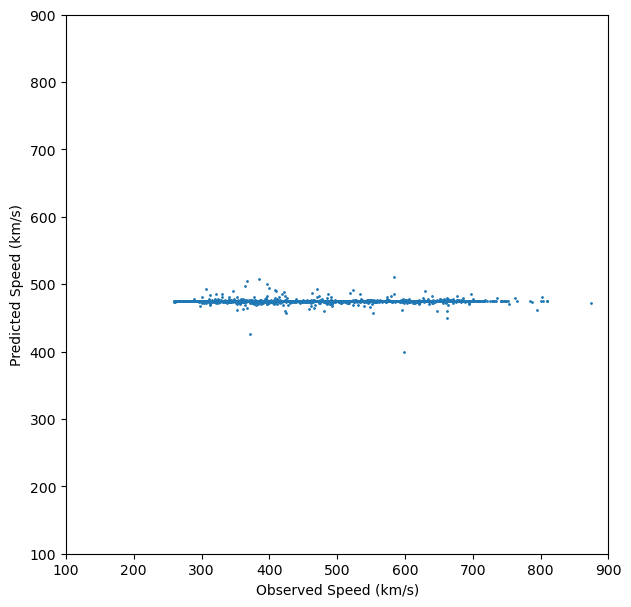

In [21]:
plt.figure(figsize=(7, 7))
plt.scatter(modified_SR_df['speed'], predict_speed, s=1)
plt.xlabel('Observed Speed (km/s)')
plt.ylabel('Predicted Speed (km/s)')
plt.xlim(100, 900)
plt.ylim(100, 900)